In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
student_life_path = module_path + "/studegymnt_life"
physnet_path = module_path + "/Physionet_rev"
print(student_life_path)
print(physnet_path)

sys.path.append(physnet_path)
sys.path.append(student_life_path)

import pandas as pd
import numpy as np
import pickle
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd


import tbm as tbm
from net_dbm import RNN_osaka


import evaluate_plot as eval_plot
import batchify as batchify
from sklearn.metrics import precision_recall_fscore_support
import importlib
import src.utils.student_utils as student_utils
import src.definitions as definitions
from IPython.display import display
from src.data_getter import student_life_var_binned_data_getter
importlib.reload(student_life_var_binned_data_getter)
importlib.reload(student_utils)

# 1 starts the process on GPU-0
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.__version__
%matplotlib inline
print(eval_plot)
print(sys.version_info)

/Users/nsimsiri/Documents/code/ml/MultiRes/student_life
/Users/nsimsiri/Documents/code/ml/MultiRes/Physionet_rev
<module 'evaluate_plot' from '/Users/nsimsiri/Documents/code/ml/MultiRes/Physionet_rev/evaluate_plot.py'>
sys.version_info(major=3, minor=6, micro=0, releaselevel='final', serial=0)


In [2]:
data = None
pickle_path = student_life_path + '/data/training_data/student_life_pickle.pkl'
model_path = student_life_path + '/models'
print('pickle_path', pickle_path)
print('model_config_path', model_path)

pickle_path /Users/nsimsiri/Documents/code/ml/MultiRes/student_life/data/training_data/student_life_pickle.pkl
model_config_path /Users/nsimsiri/Documents/code/ml/MultiRes/student_life/models


In [3]:
with open(pickle_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
print(data.keys())

dict_keys(['train_ids', 'val_ids', 'test_ids', 'data'])


In [4]:
params = {'bilstm_flag':True,
        'hidden_dim' : 32,
        'input_dim':50,
        'dropout' : 0.9,
        'layers' : 1,
        'tagset_size' : 5,
        'bilstm_flag' : True,
        'attn_category' : 'dot',
        'num_features' : 10,
        'batch_size':1,
        'model_name':'TBM-SL-'}

model_config_path = model_path + "/" + params['model_name']+'.pt'
print(model_config_path)
with open(model_config_path, 'wb') as config_file:
    pickle.dump(params, config_file)
    


/Users/nsimsiri/Documents/code/ml/MultiRes/student_life/models/TBM-SL-.pt


In [5]:
model_RNN = tbm.RNN_osaka(params)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model_RNN.parameters(), lr=0.0001, weight_decay=0.000000002)


Dot Attention is being used!


/Users/nsimsiri/anaconda2/envs/python3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
mode = 'normal'
if(mode=='normal'):
    feature_ind = 0
    label_ind = -1
    print("NORMAL mode with Flags")

NORMAL mode with Flags


In [7]:
batch_size = 1
epochs = 45
save_flag = True
dict_df_prf_mod = {}
print("==x=="*20)
print("Data Statistics")
print("Train Data: "+str(len(data['train_ids'])))
print("Val Data: "+str(len(data['val_ids'])))
print("Test Data: "+str(len(data['test_ids'])))
print("==x=="*20)

==x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x==
Data Statistics
Train Data: 17
Val Data: 5
Test Data: 7
==x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x==


  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=0=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.13it/s]
/Users/nsimsiri/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nsimsiri/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


==========Epoch No:0==========
Training Loss: 28.59961438179016
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




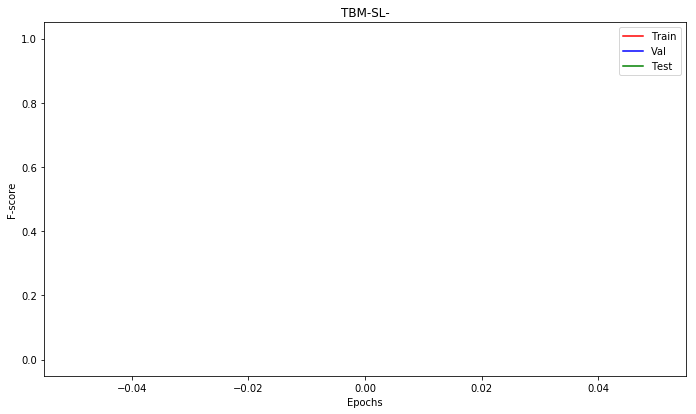

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=1=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


==========Epoch No:1==========
Training Loss: 28.488139748573303
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




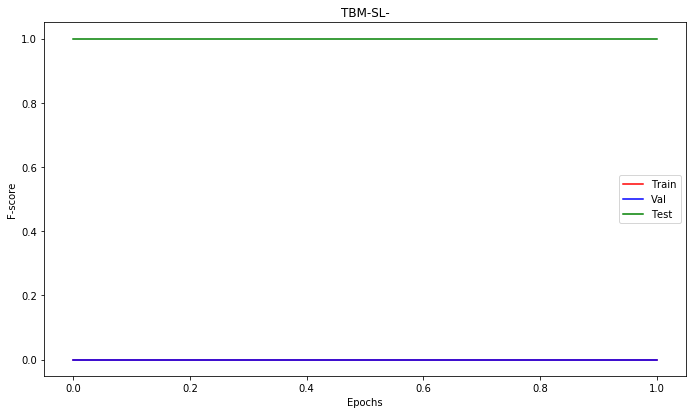

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=2=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


==========Epoch No:2==========
Training Loss: 28.398656368255615
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




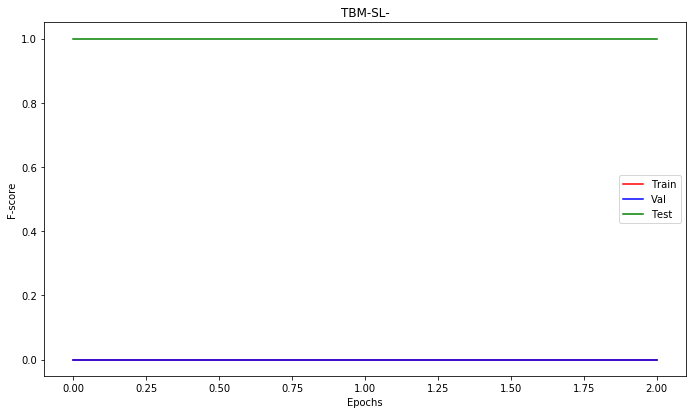

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=3=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


==========Epoch No:3==========
Training Loss: 28.305166840553284
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




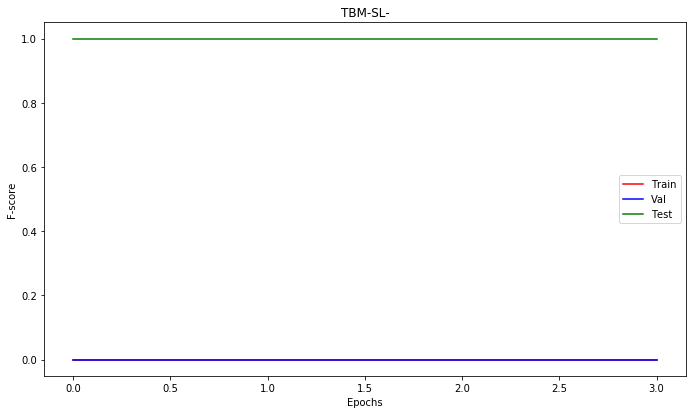

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=4=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.07it/s]


==========Epoch No:4==========
Training Loss: 28.218965530395508
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




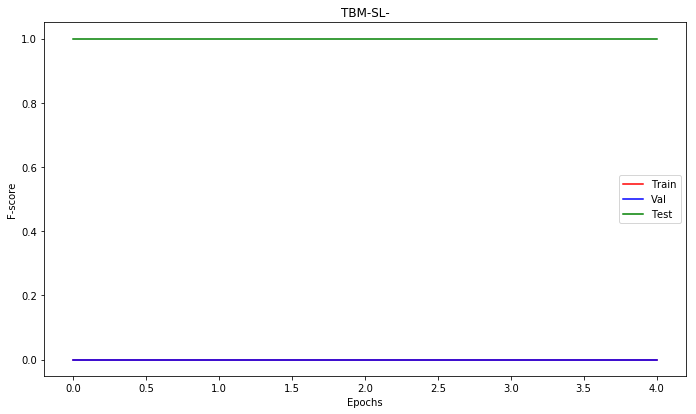

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=5=#==#==#==#==#=


100%|██████████| 17/17 [00:21<00:00,  1.47s/it]


==========Epoch No:5==========
Training Loss: 28.141593098640442
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




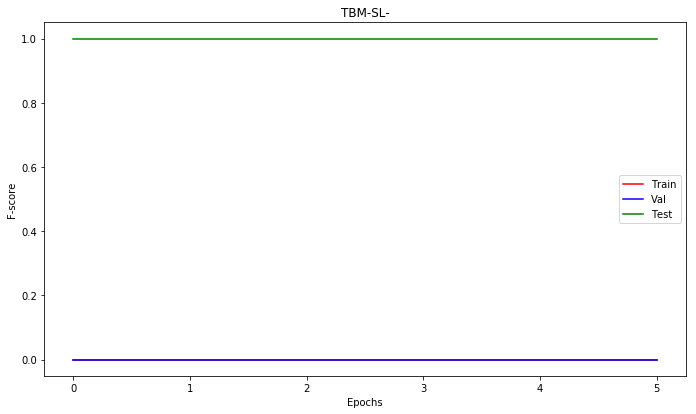

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=6=#==#==#==#==#=


100%|██████████| 17/17 [00:25<00:00,  2.13s/it]


==========Epoch No:6==========
Training Loss: 28.06803607940674
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




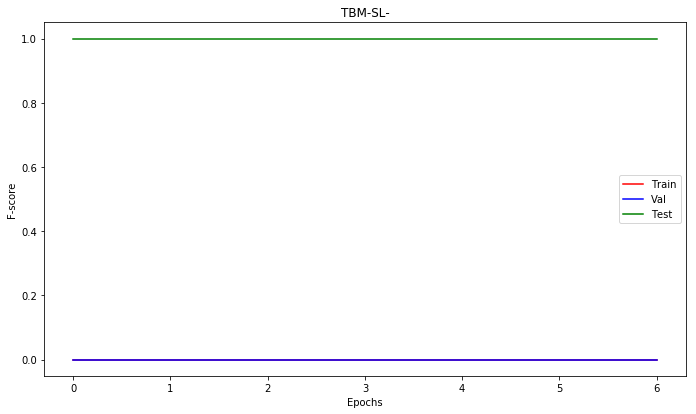

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=7=#==#==#==#==#=


100%|██████████| 17/17 [00:19<00:00,  1.07s/it]


==========Epoch No:7==========
Training Loss: 27.997126579284668
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




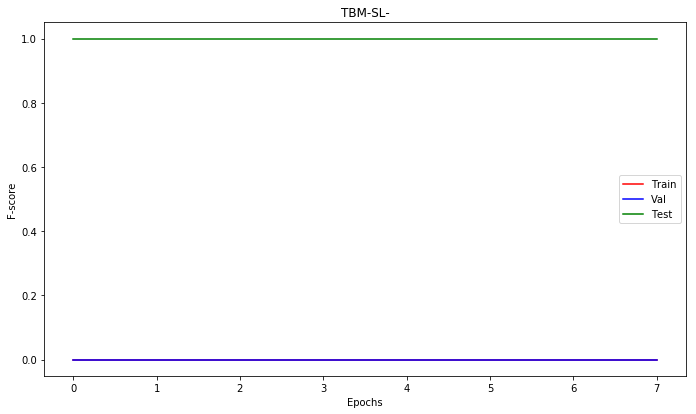

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=8=#==#==#==#==#=


100%|██████████| 17/17 [00:22<00:00,  1.36s/it]


==========Epoch No:8==========
Training Loss: 27.927781462669373
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




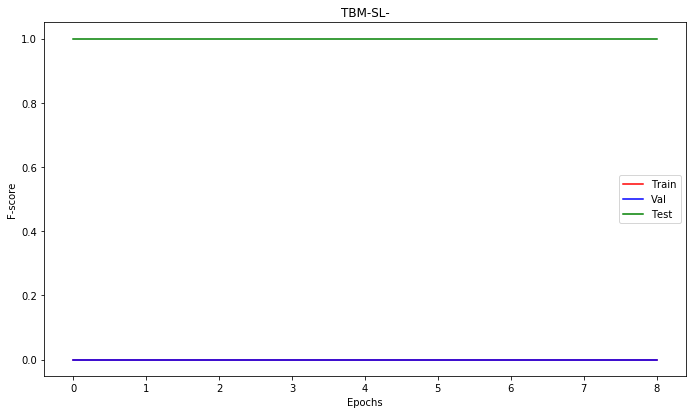

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=9=#==#==#==#==#=


100%|██████████| 17/17 [00:27<00:00,  1.20s/it]


==========Epoch No:9==========
Training Loss: 27.858875274658203
Train: (0.4117647058823529, 0.058823529411764705, 0.10294117647058823, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      3.0  6.0
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




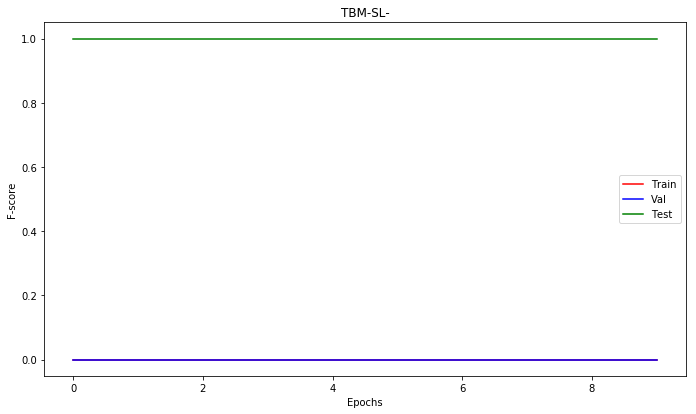

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=10=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.11it/s]


==========Epoch No:10==========
Training Loss: 27.79146647453308
Train: (0.7647058823529411, 0.11764705882352941, 0.20378151260504201, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.166667
F-score    0.0  0.285714
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




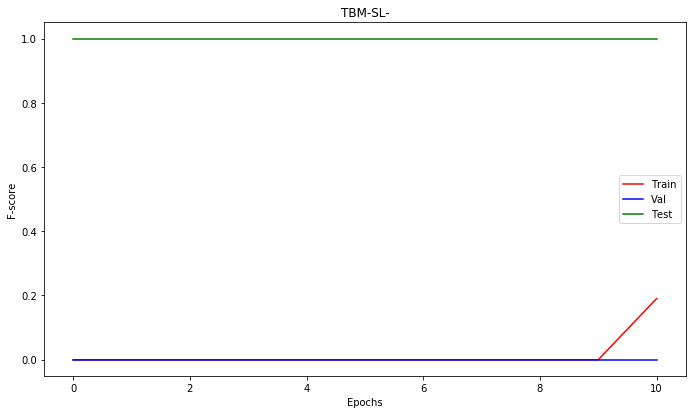

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=11=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


==========Epoch No:11==========
Training Loss: 27.726415514945984
Train: (0.7647058823529411, 0.11764705882352941, 0.20378151260504201, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.166667
F-score    0.0  0.285714
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




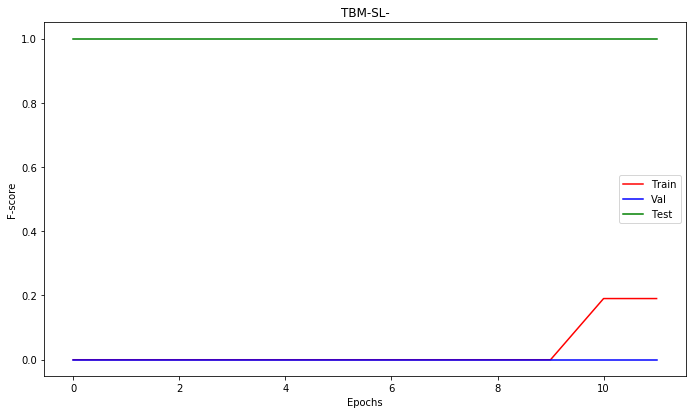

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=12=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.19it/s]


==========Epoch No:12==========
Training Loss: 27.66340959072113
Train: (0.7647058823529411, 0.11764705882352941, 0.20378151260504201, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.166667
F-score    0.0  0.285714
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




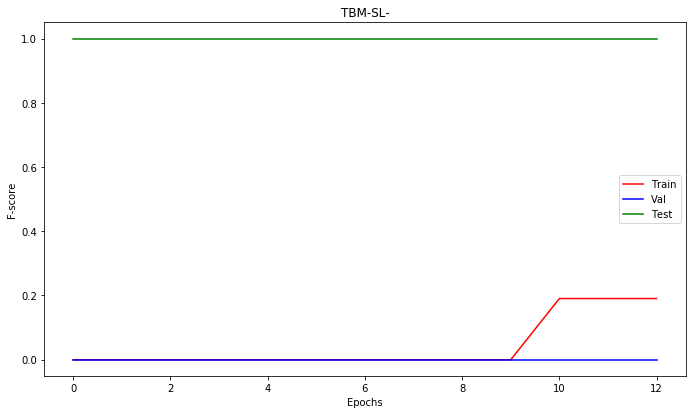

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=13=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


==========Epoch No:13==========
Training Loss: 27.5986989736557
Train: (0.7647058823529411, 0.11764705882352941, 0.20378151260504201, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.166667
F-score    0.0  0.285714
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




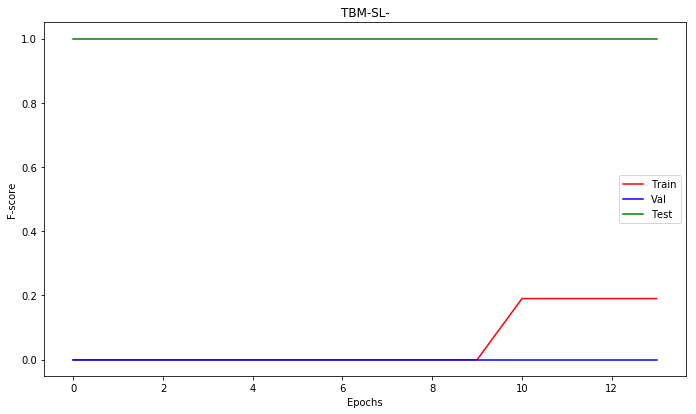

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=14=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


==========Epoch No:14==========
Training Loss: 27.46798348426819
Train: (0.7647058823529411, 0.11764705882352941, 0.20378151260504201, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.166667
F-score    0.0  0.285714
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




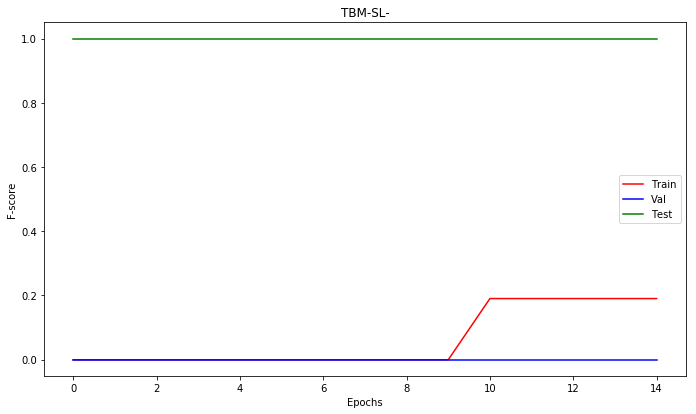

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=15=#==#==#==#==#=


100%|██████████| 17/17 [00:19<00:00,  1.10it/s]


==========Epoch No:15==========
Training Loss: 27.477596044540405
Train: (0.7647058823529411, 0.17647058823529413, 0.27941176470588236, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.333333
F-score    0.0  0.500000
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




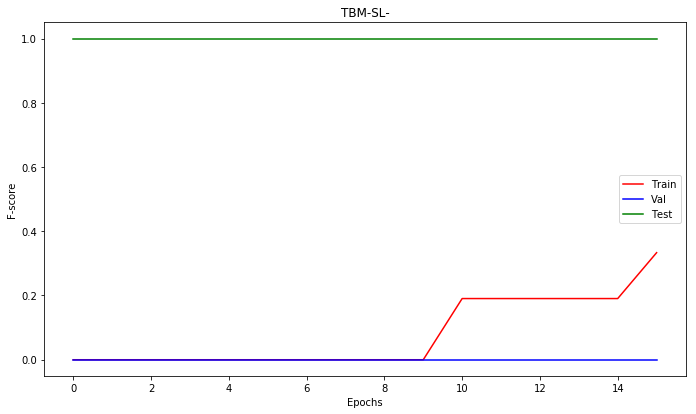

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=16=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.17it/s]


==========Epoch No:16==========
Training Loss: 27.417790293693542
Train: (0.7647058823529411, 0.17647058823529413, 0.27941176470588236, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.333333
F-score    0.0  0.500000
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




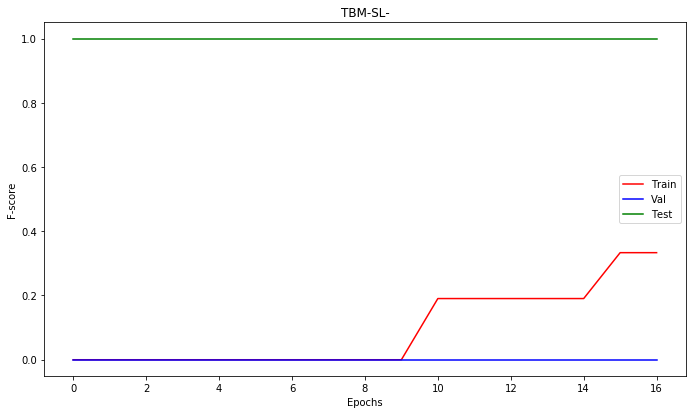

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=17=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.22s/it]


==========Epoch No:17==========
Training Loss: 27.335196137428284
Train: (0.7647058823529411, 0.17647058823529413, 0.27941176470588236, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.333333
F-score    0.0  0.500000
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




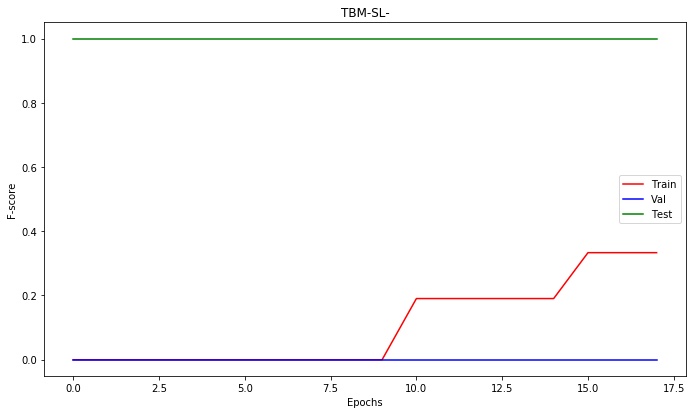

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=18=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.18it/s]


==========Epoch No:18==========
Training Loss: 27.244261384010315
Train: (0.7647058823529411, 0.17647058823529413, 0.27941176470588236, None)
             0         1
Precision  0.0  1.000000
Recall     0.0  0.333333
F-score    0.0  0.500000
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




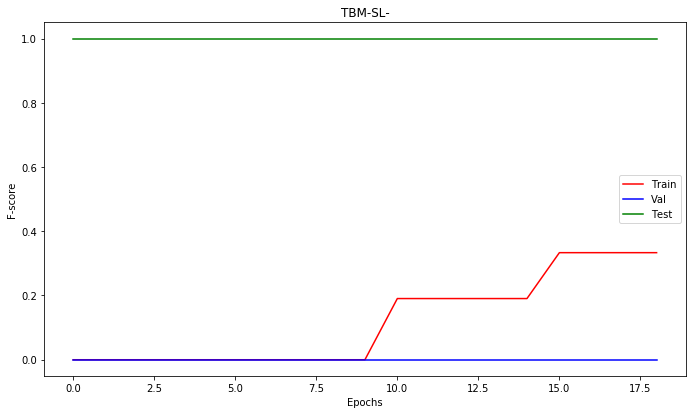

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=19=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.14s/it]


==========Epoch No:19==========
Training Loss: 27.20017123222351
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




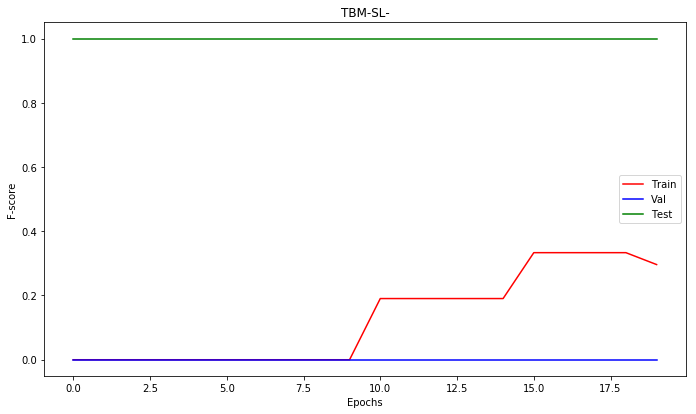

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=20=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.07it/s]


==========Epoch No:20==========
Training Loss: 27.158356547355652
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




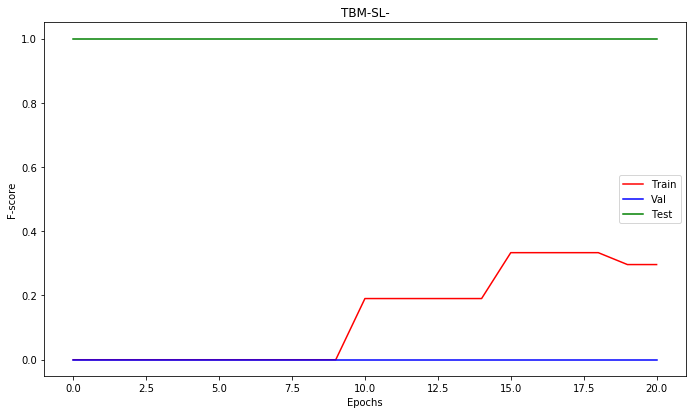

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=21=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


==========Epoch No:21==========
Training Loss: 27.117904543876648
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




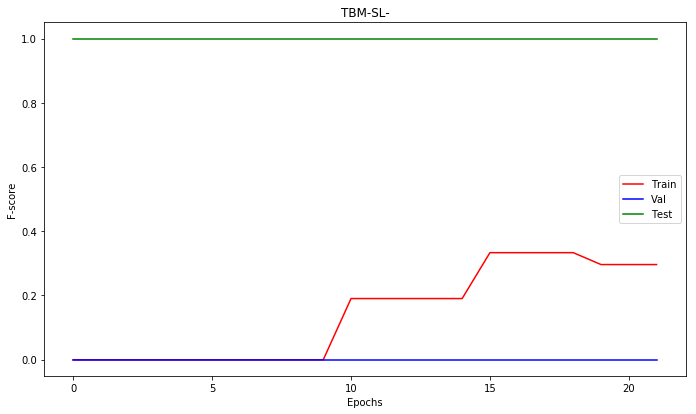

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=22=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.18it/s]


==========Epoch No:22==========
Training Loss: 27.078285455703735
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




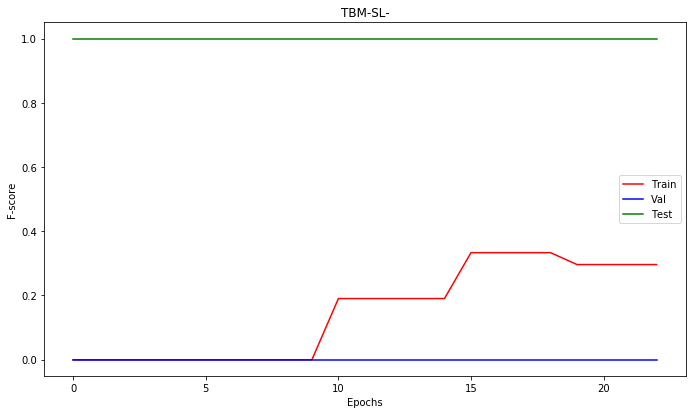

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=23=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


==========Epoch No:23==========
Training Loss: 27.03908085823059
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




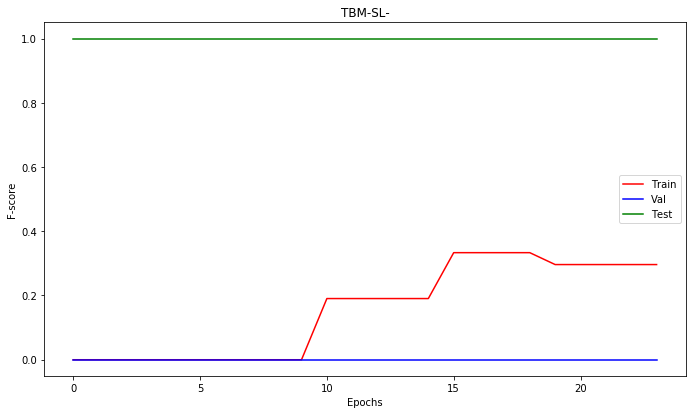

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=24=#==#==#==#==#=


100%|██████████| 17/17 [00:28<00:00,  1.50s/it]


==========Epoch No:24==========
Training Loss: 26.99990451335907
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




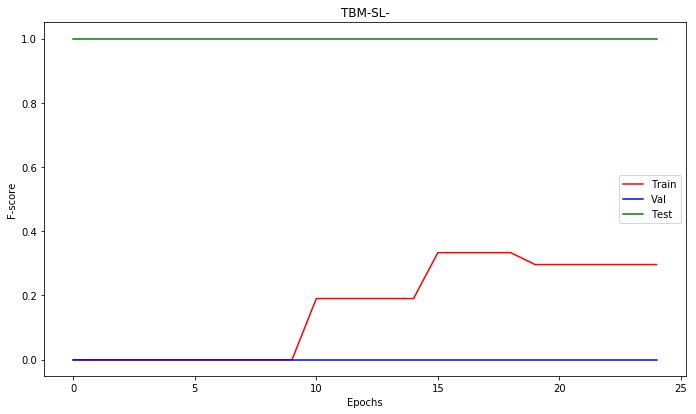

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=25=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.16it/s]


==========Epoch No:25==========
Training Loss: 26.960628509521484
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




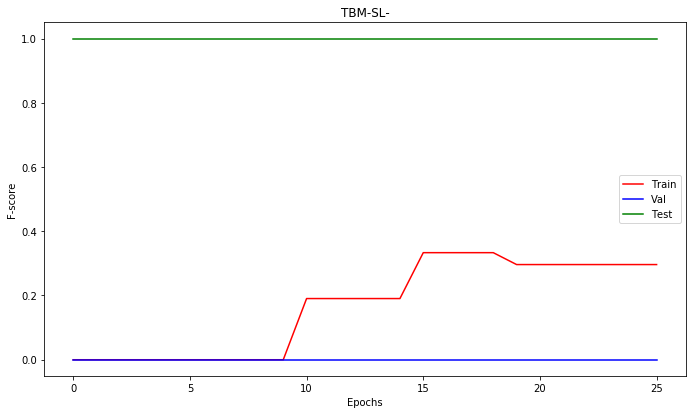

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=26=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


==========Epoch No:26==========
Training Loss: 26.921836972236633
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




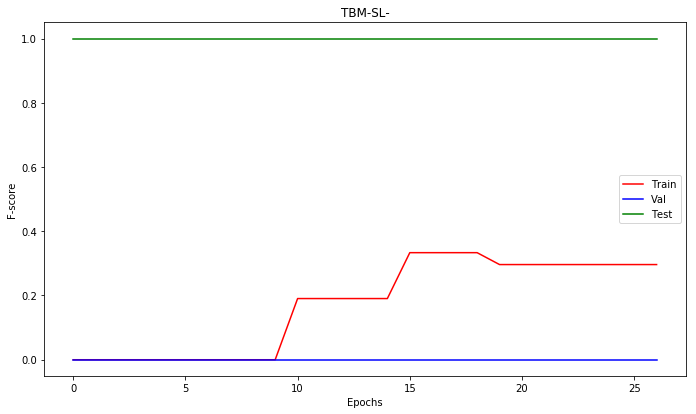

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=27=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


==========Epoch No:27==========
Training Loss: 26.88438856601715
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




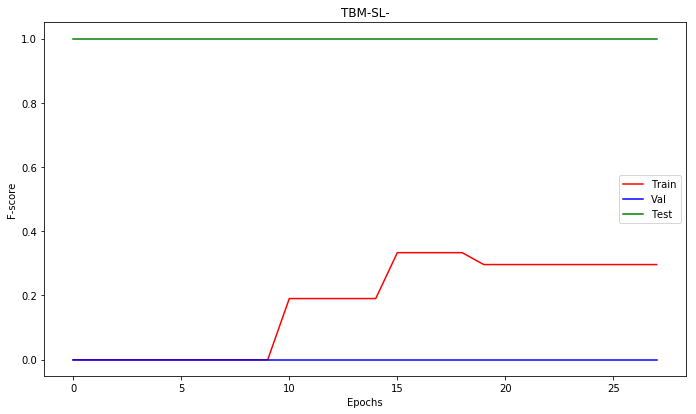

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=28=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.18s/it]


==========Epoch No:28==========
Training Loss: 26.84852111339569
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




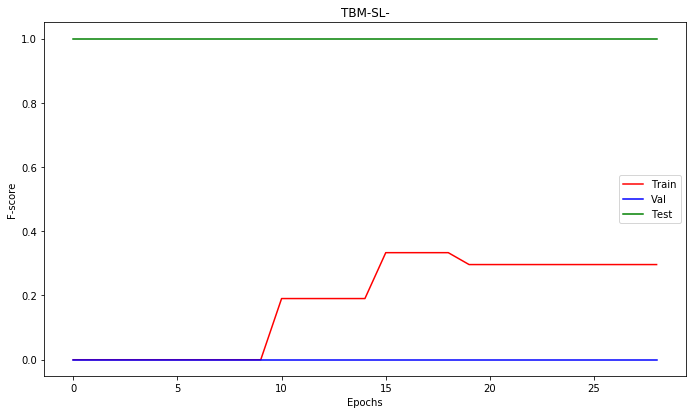

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=29=#==#==#==#==#=


100%|██████████| 17/17 [00:20<00:00,  1.24s/it]


==========Epoch No:29==========
Training Loss: 26.81393790245056
Train: (0.6470588235294118, 0.17647058823529413, 0.2598039215686274, None)
             0         1
Precision  0.0  0.666667
Recall     0.0  0.333333
F-score    0.0  0.444444
Count      3.0  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




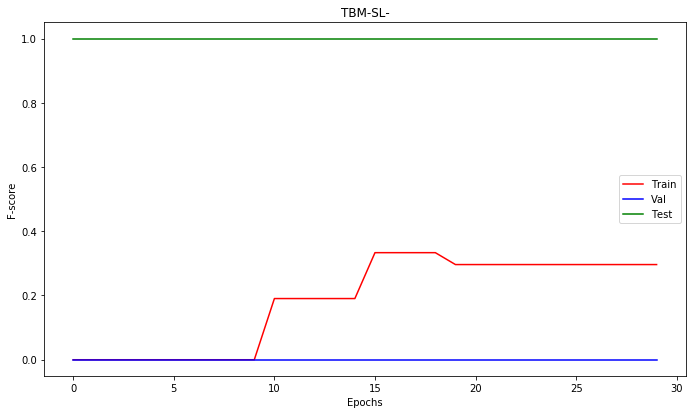

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=30=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


==========Epoch No:30==========
Training Loss: 26.780322313308716
Train: (0.6764705882352942, 0.23529411764705882, 0.31470588235294117, None)
             0     1
Precision  0.0  0.75
Recall     0.0  0.50
F-score    0.0  0.60
Count      3.0  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




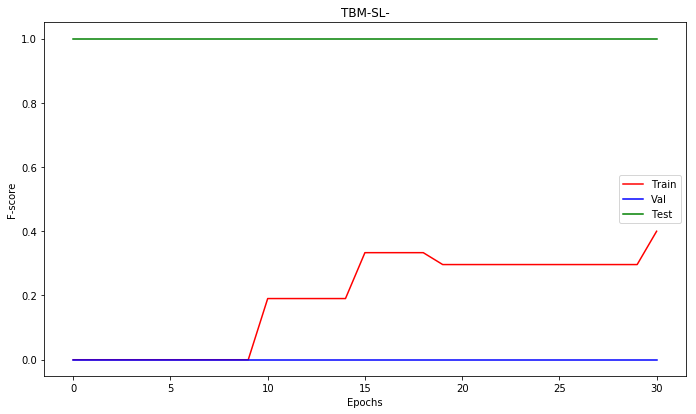

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=31=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.14it/s]


==========Epoch No:31==========
Training Loss: 26.74746572971344
Train: (0.6764705882352942, 0.23529411764705882, 0.31470588235294117, None)
             0     1
Precision  0.0  0.75
Recall     0.0  0.50
F-score    0.0  0.60
Count      3.0  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




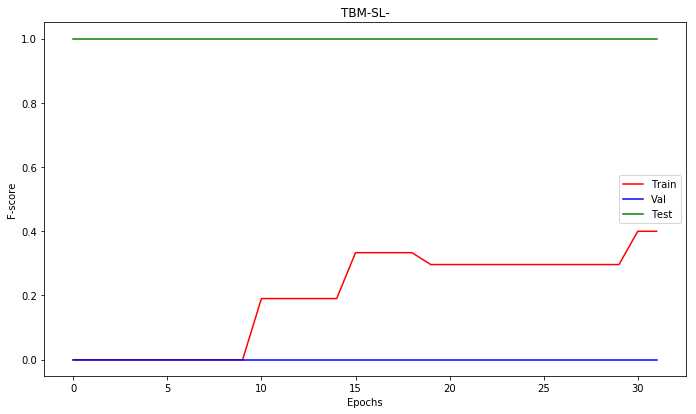

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=32=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


==========Epoch No:32==========
Training Loss: 26.715237617492676
Train: (0.6764705882352942, 0.23529411764705882, 0.31470588235294117, None)
             0     1
Precision  0.0  0.75
Recall     0.0  0.50
F-score    0.0  0.60
Count      3.0  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




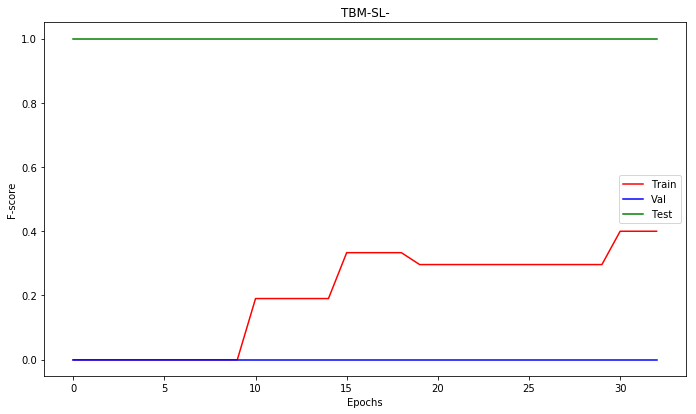

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=33=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.10it/s]


==========Epoch No:33==========
Training Loss: 26.68352222442627
Train: (0.6764705882352942, 0.23529411764705882, 0.31470588235294117, None)
             0     1
Precision  0.0  0.75
Recall     0.0  0.50
F-score    0.0  0.60
Count      3.0  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




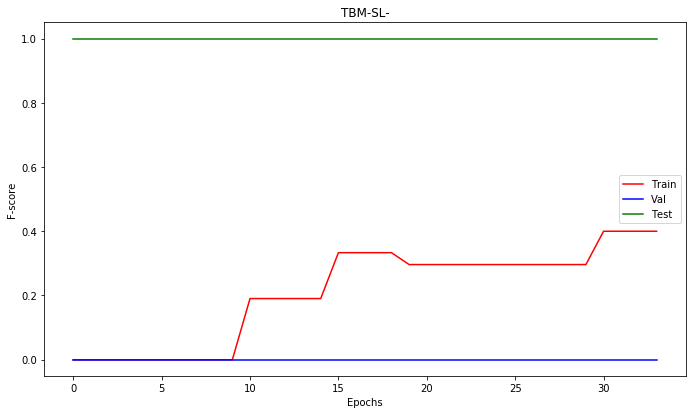

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=34=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


==========Epoch No:34==========
Training Loss: 26.65224838256836
Train: (0.6764705882352942, 0.23529411764705882, 0.31470588235294117, None)
             0     1
Precision  0.0  0.75
Recall     0.0  0.50
F-score    0.0  0.60
Count      3.0  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




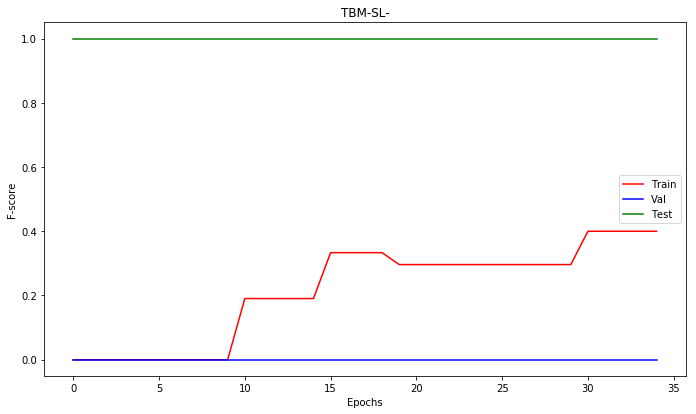

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=35=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


==========Epoch No:35==========
Training Loss: 26.621363401412964
Train: (0.6764705882352942, 0.23529411764705882, 0.31470588235294117, None)
             0     1
Precision  0.0  0.75
Recall     0.0  0.50
F-score    0.0  0.60
Count      3.0  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




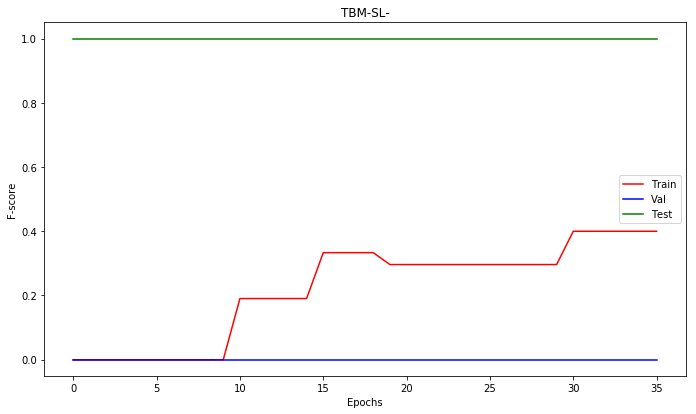

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=36=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.30s/it]


==========Epoch No:36==========
Training Loss: 26.590803742408752
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




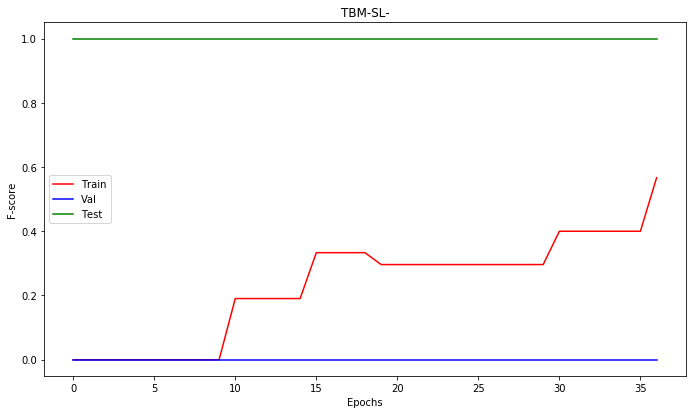

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=37=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.06it/s]


==========Epoch No:37==========
Training Loss: 26.560548663139343
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




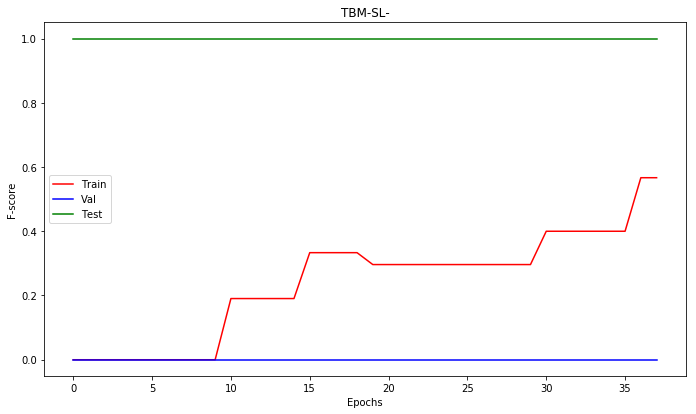

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=38=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.12it/s]


==========Epoch No:38==========
Training Loss: 26.530558705329895
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




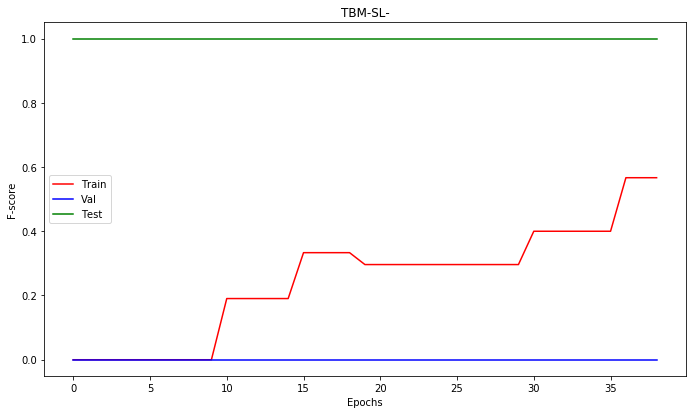

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=39=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


==========Epoch No:39==========
Training Loss: 26.500797510147095
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




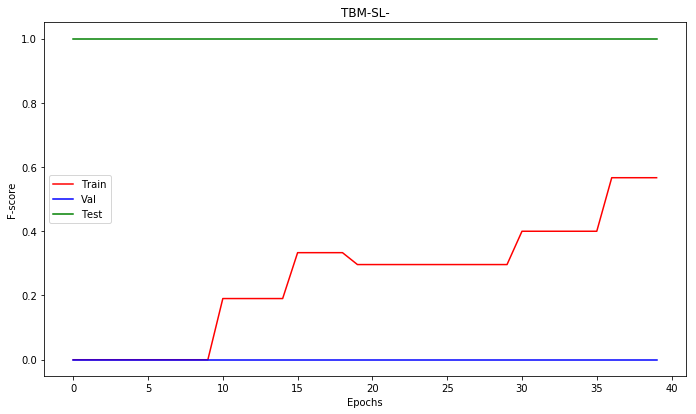

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=40=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


==========Epoch No:40==========
Training Loss: 26.47125279903412
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




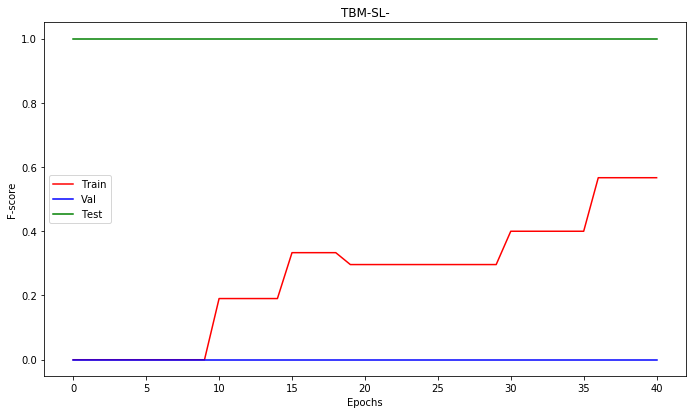

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=41=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.12it/s]


==========Epoch No:41==========
Training Loss: 26.44190490245819
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




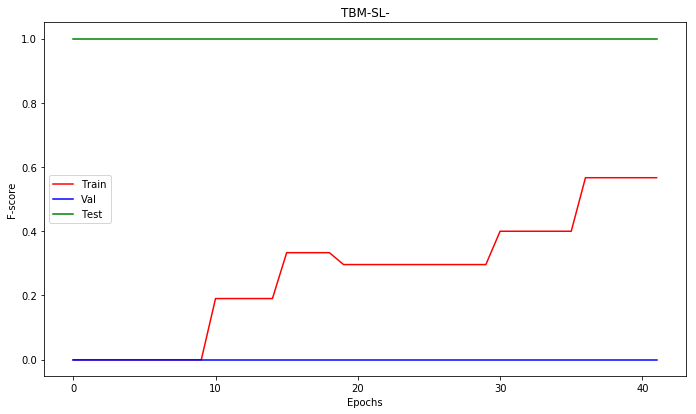

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=42=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.08s/it]


==========Epoch No:42==========
Training Loss: 26.41271662712097
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




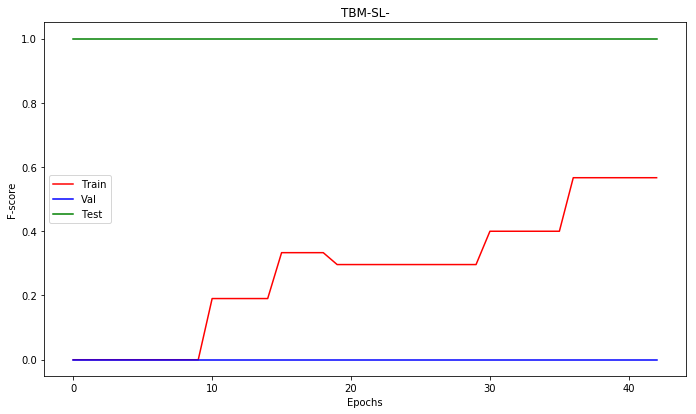

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=43=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.10it/s]


==========Epoch No:43==========
Training Loss: 26.38368308544159
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




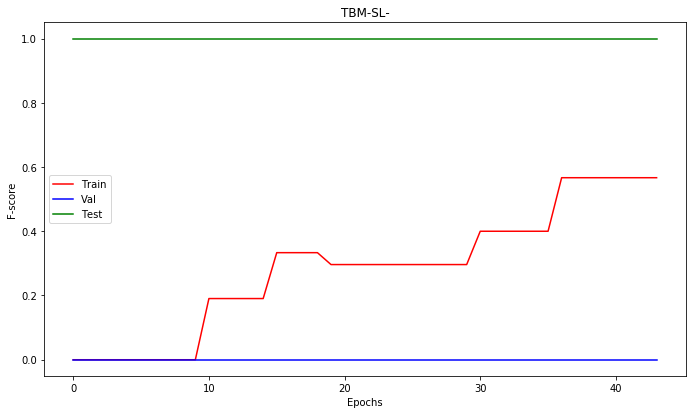

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=44=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


==========Epoch No:44==========
Training Loss: 26.354775309562683
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




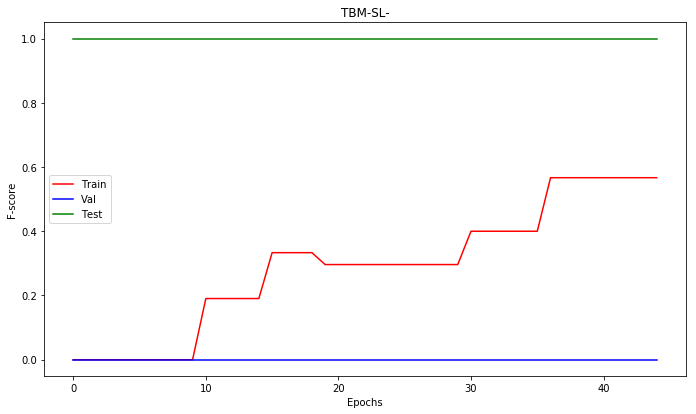

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=45=#==#==#==#==#=


100%|██████████| 17/17 [00:19<00:00,  1.02it/s]


==========Epoch No:45==========
Training Loss: 26.325973629951477
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




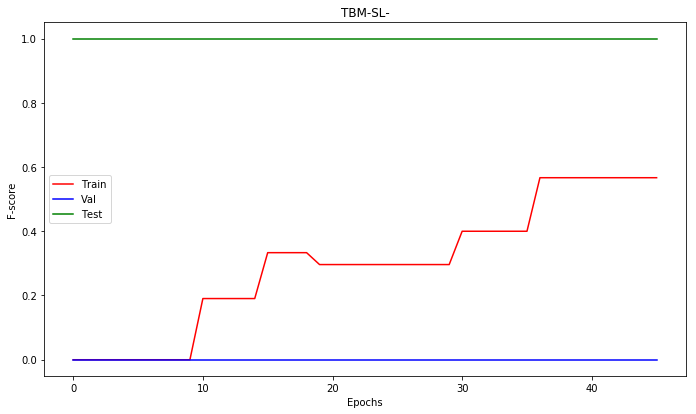

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=46=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.02s/it]


==========Epoch No:46==========
Training Loss: 26.29724895954132
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




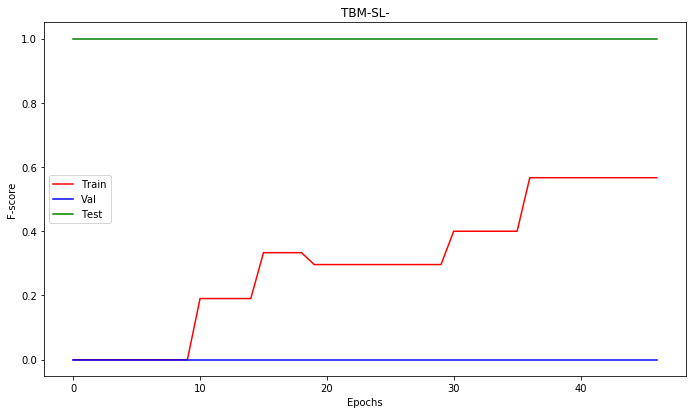

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=47=#==#==#==#==#=


100%|██████████| 17/17 [00:26<00:00,  1.89s/it]


==========Epoch No:47==========
Training Loss: 26.26857078075409
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




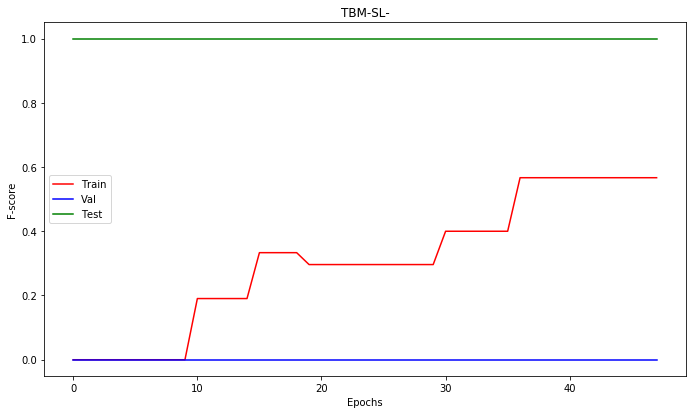

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=48=#==#==#==#==#=


100%|██████████| 17/17 [00:19<00:00,  1.17it/s]


==========Epoch No:48==========
Training Loss: 26.239900946617126
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




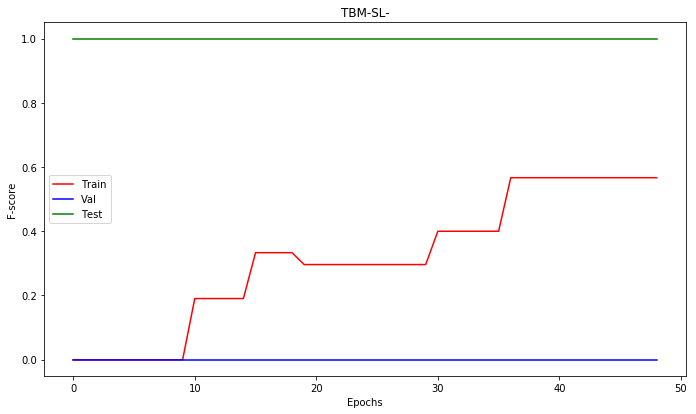

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=49=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


==========Epoch No:49==========
Training Loss: 26.211189031600952
Train: (0.8529411764705882, 0.29411764705882354, 0.4029411764705882, None)
                  0     1
Precision  1.000000  0.75
Recall     0.333333  0.50
F-score    0.500000  0.60
Count      3.000000  6.00
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




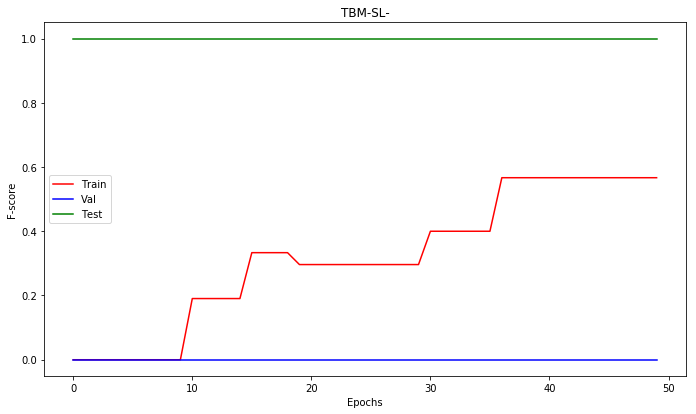

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=50=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.02s/it]


==========Epoch No:50==========
Training Loss: 26.18235683441162
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




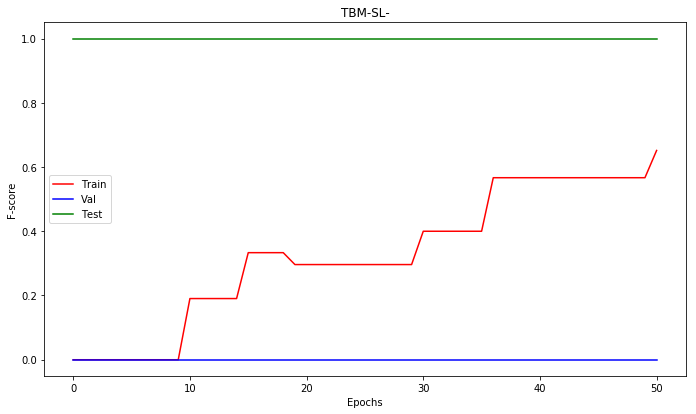

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=51=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.16it/s]


==========Epoch No:51==========
Training Loss: 26.15330696105957
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




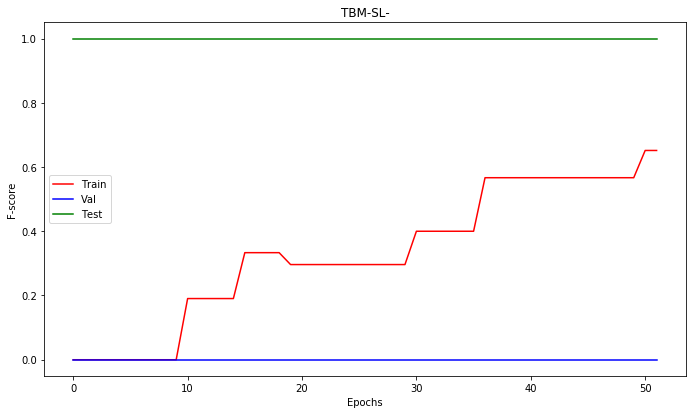

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=52=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.17it/s]


==========Epoch No:52==========
Training Loss: 26.12389588356018
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




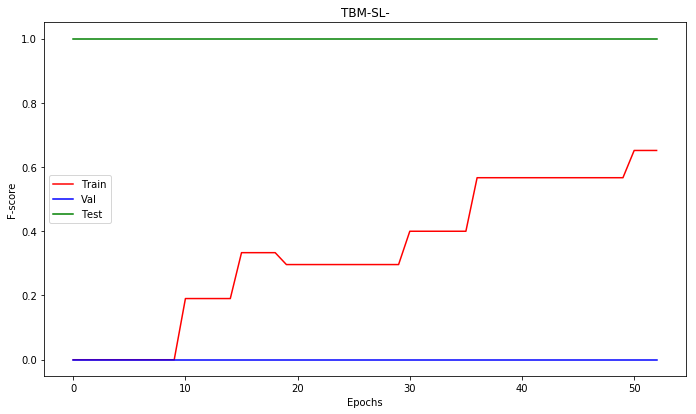

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=53=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.19it/s]


==========Epoch No:53==========
Training Loss: 26.093895435333252
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




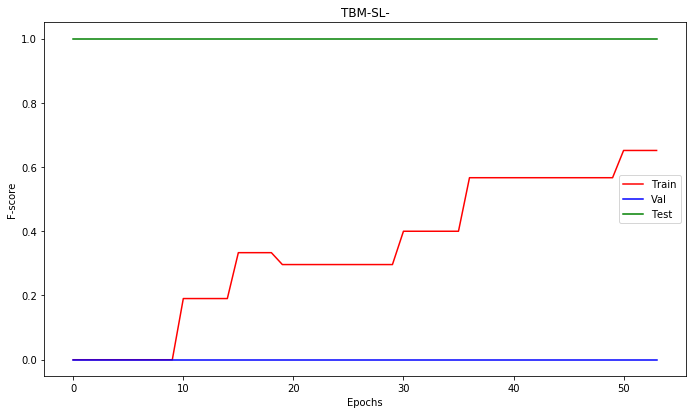

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=54=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


==========Epoch No:54==========
Training Loss: 26.06295955181122
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




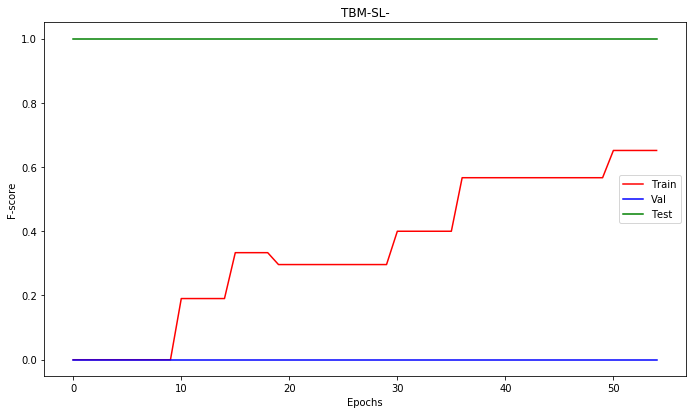

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=55=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


==========Epoch No:55==========
Training Loss: 26.03054642677307
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




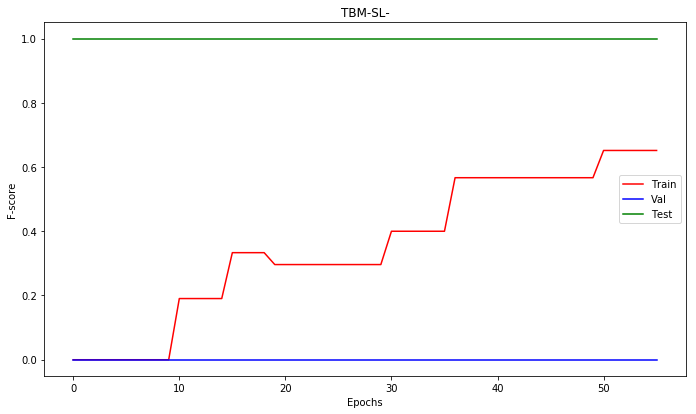

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=56=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.14it/s]


==========Epoch No:56==========
Training Loss: 25.99581003189087
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




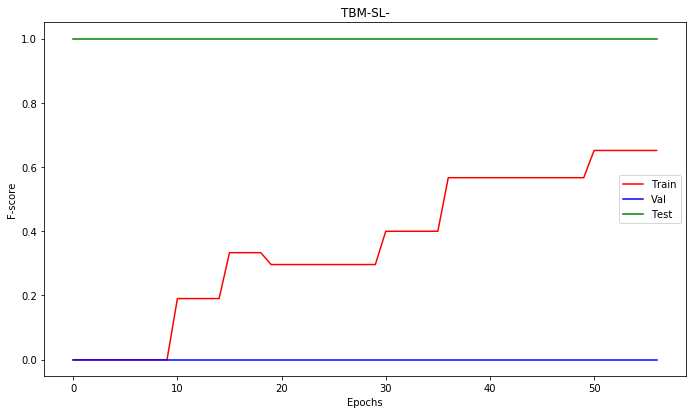

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=57=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.16it/s]


==========Epoch No:57==========
Training Loss: 25.95767116546631
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




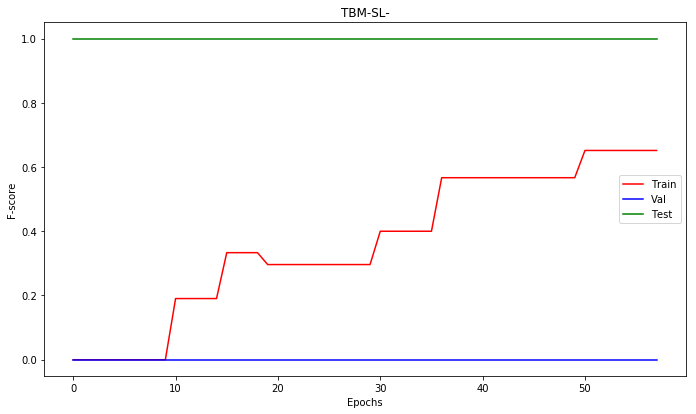

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=58=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


==========Epoch No:58==========
Training Loss: 25.91541290283203
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




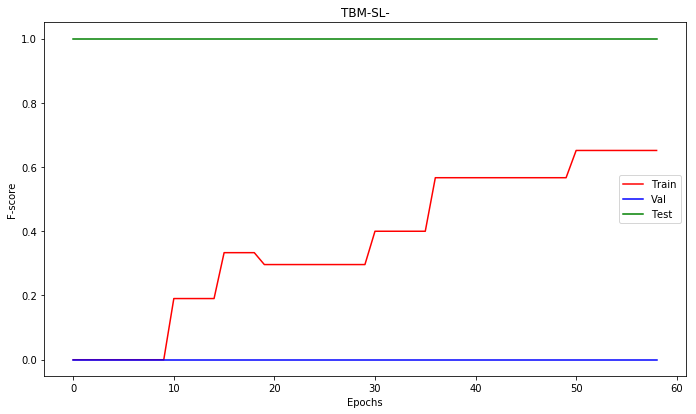

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=59=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


==========Epoch No:59==========
Training Loss: 25.870441555976868
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




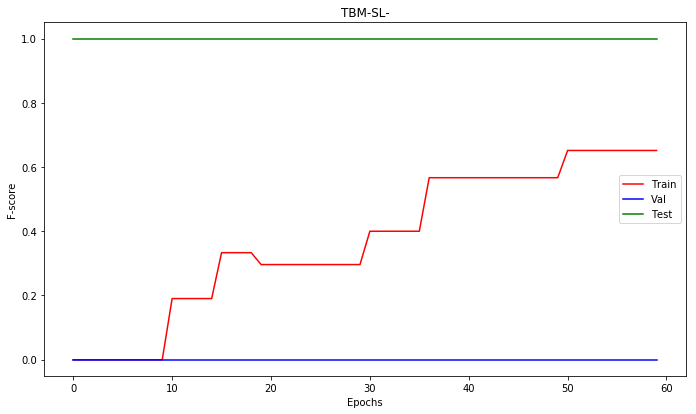

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=60=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


==========Epoch No:60==========
Training Loss: 25.826799869537354
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




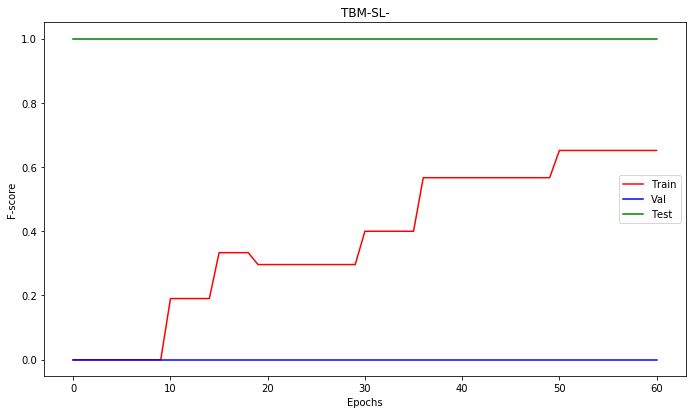

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=61=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


==========Epoch No:61==========
Training Loss: 25.787118673324585
Train: (0.8705882352941177, 0.35294117647058826, 0.4478609625668449, None)
                  0         1
Precision  1.000000  0.800000
Recall     0.333333  0.666667
F-score    0.500000  0.727273
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




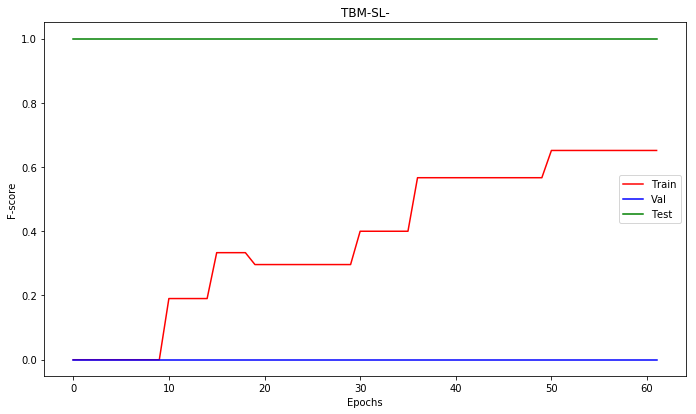

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=62=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


==========Epoch No:62==========
Training Loss: 25.75022602081299
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




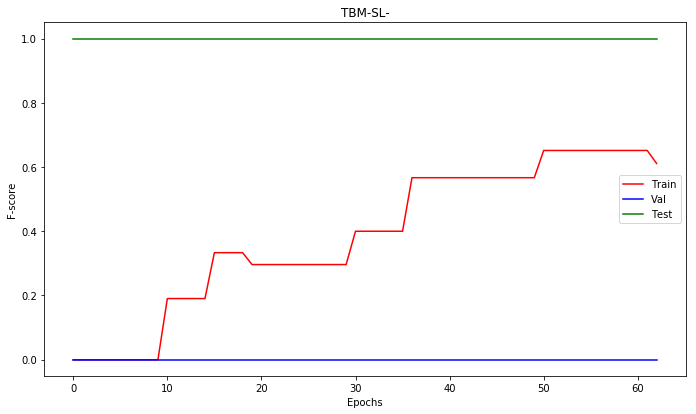

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=63=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


==========Epoch No:63==========
Training Loss: 25.71307134628296
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




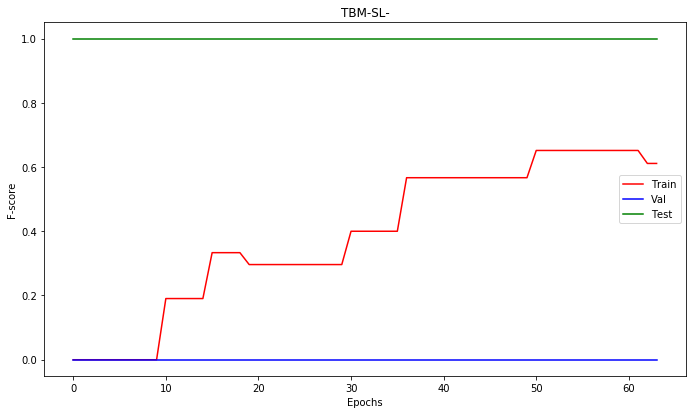

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=64=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


==========Epoch No:64==========
Training Loss: 25.672768354415894
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




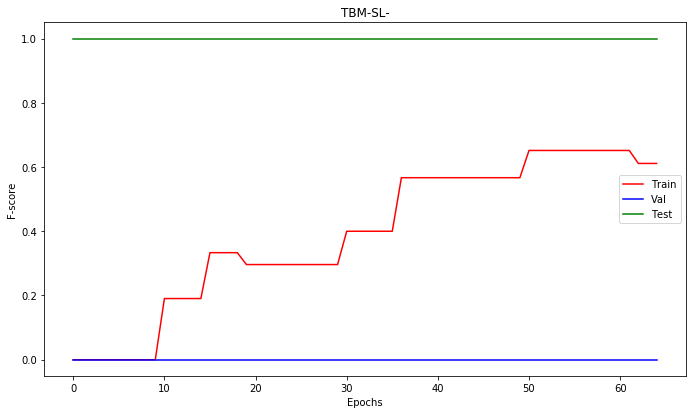

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=65=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


==========Epoch No:65==========
Training Loss: 25.635735988616943
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




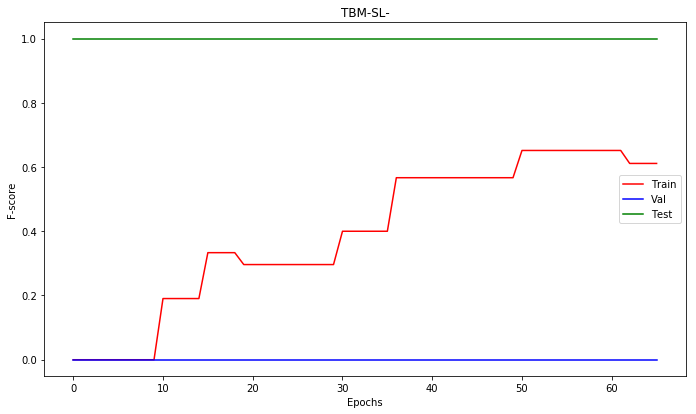

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=66=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


==========Epoch No:66==========
Training Loss: 25.603943586349487
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.4, 0.2, 0.26666666666666666, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




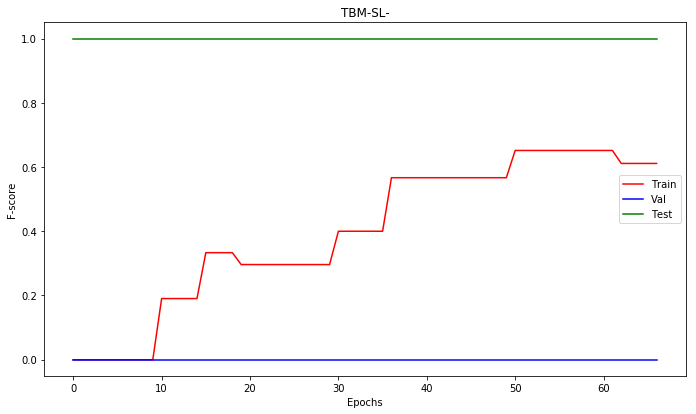

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=67=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


==========Epoch No:67==========
Training Loss: 25.572499752044678
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.8571428571428571, 0.2857142857142857, 0.380952380952381, None)
             0    1
Precision  1.0  0.0
Recall     1.0  0.0
F-score    1.0  0.0
Count      1.0  0.0




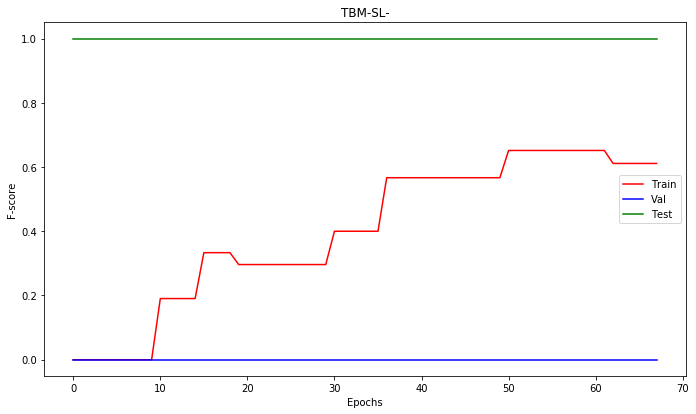

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=68=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.12it/s]


==========Epoch No:68==========
Training Loss: 25.5405296087265
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




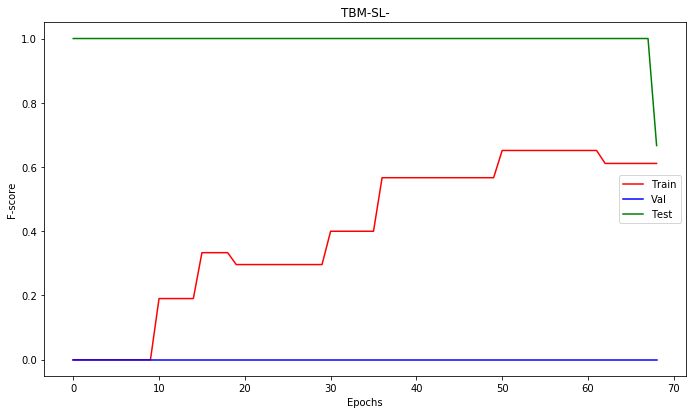

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=69=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.06it/s]


==========Epoch No:69==========
Training Loss: 25.50776731967926
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




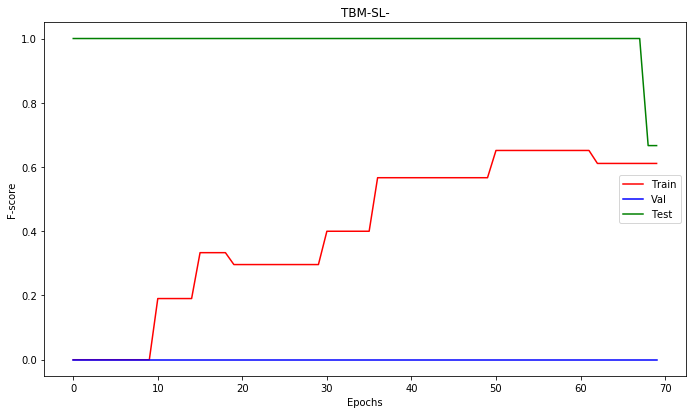

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=70=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


==========Epoch No:70==========
Training Loss: 25.474292635917664
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




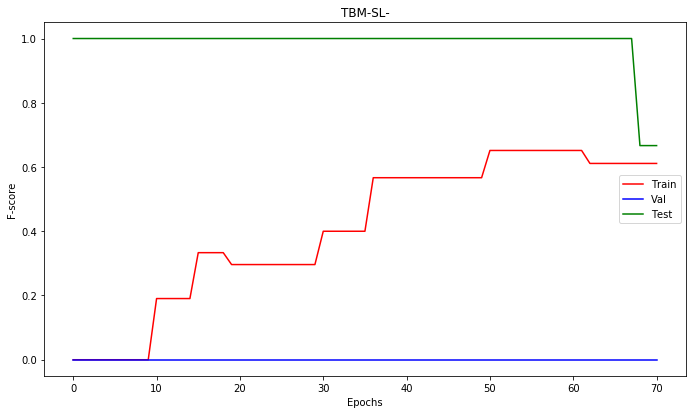

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=71=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


==========Epoch No:71==========
Training Loss: 25.44049072265625
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




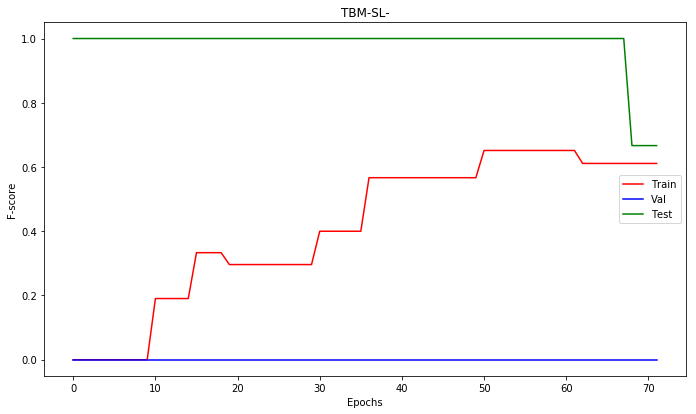

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=72=#==#==#==#==#=


100%|██████████| 17/17 [00:16<00:00,  1.13it/s]


==========Epoch No:72==========
Training Loss: 25.406935453414917
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




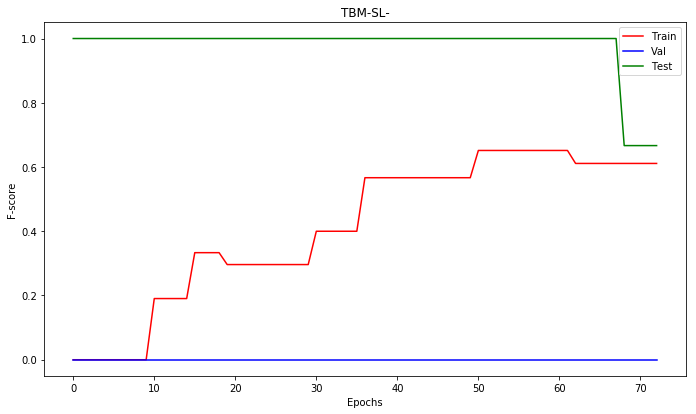

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=73=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.19it/s]


==========Epoch No:73==========
Training Loss: 25.374136209487915
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




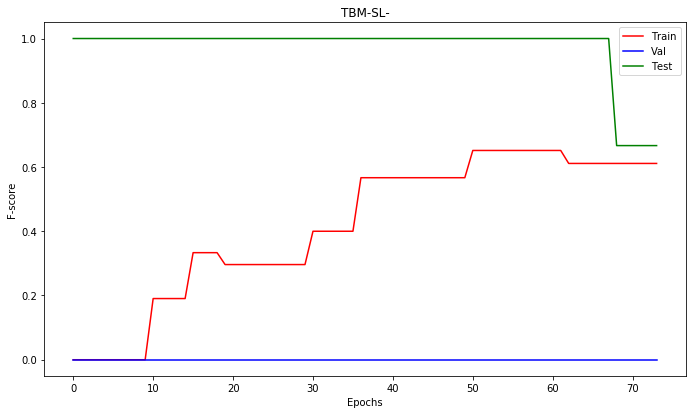

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=74=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.14it/s]


==========Epoch No:74==========
Training Loss: 25.34234356880188
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




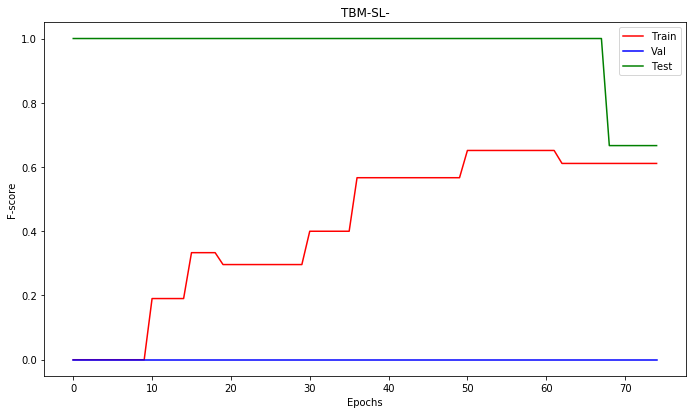

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=75=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


==========Epoch No:75==========
Training Loss: 25.311548948287964
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




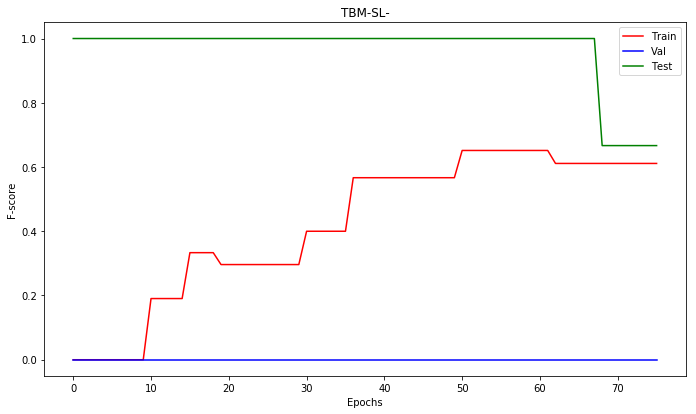

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=76=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.00s/it]


==========Epoch No:76==========
Training Loss: 25.281556487083435
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




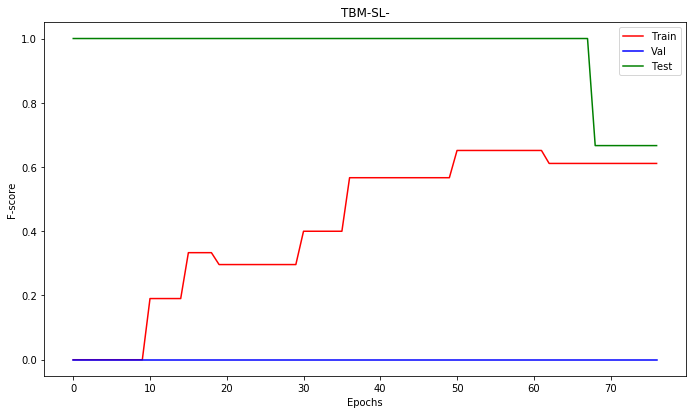

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=77=#==#==#==#==#=


100%|██████████| 17/17 [00:19<00:00,  1.13it/s]


==========Epoch No:77==========
Training Loss: 25.252082347869873
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




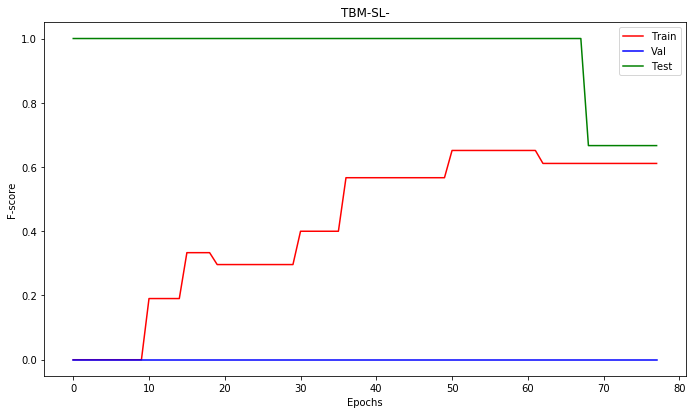

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=78=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.05it/s]


==========Epoch No:78==========
Training Loss: 25.22284984588623
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




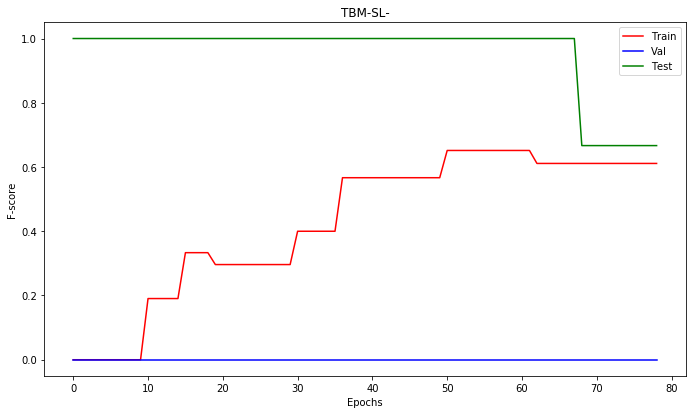

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=79=#==#==#==#==#=


100%|██████████| 17/17 [00:17<00:00,  1.16it/s]


==========Epoch No:79==========
Training Loss: 25.19366145133972
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




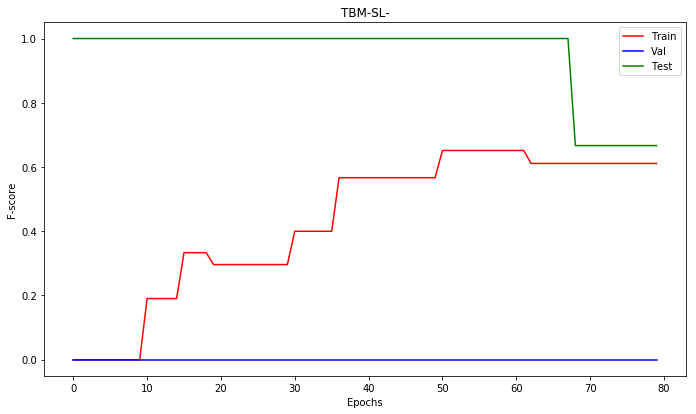

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=80=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


==========Epoch No:80==========
Training Loss: 25.16445815563202
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




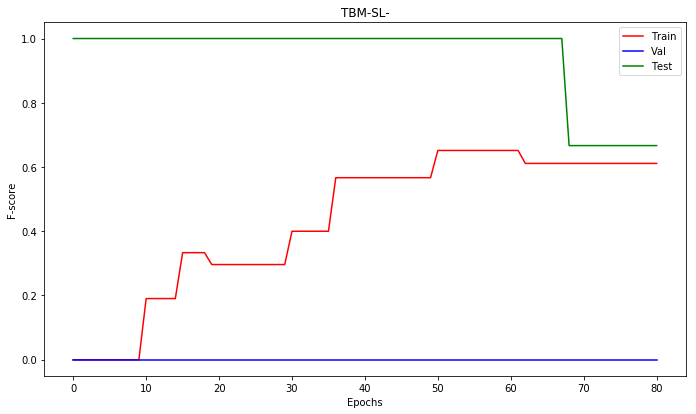

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=81=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.16it/s]


==========Epoch No:81==========
Training Loss: 25.13539731502533
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




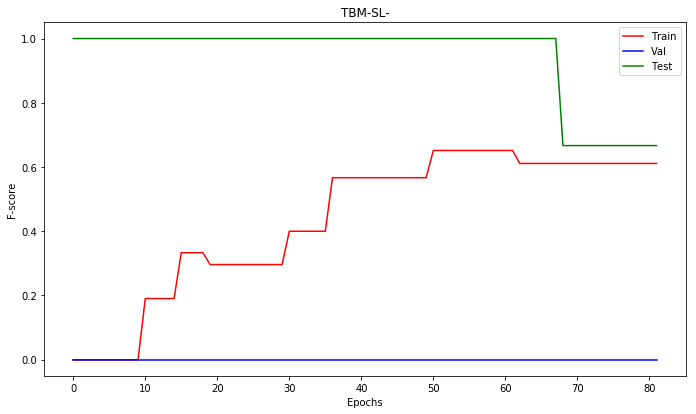

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=82=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


==========Epoch No:82==========
Training Loss: 25.10679042339325
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




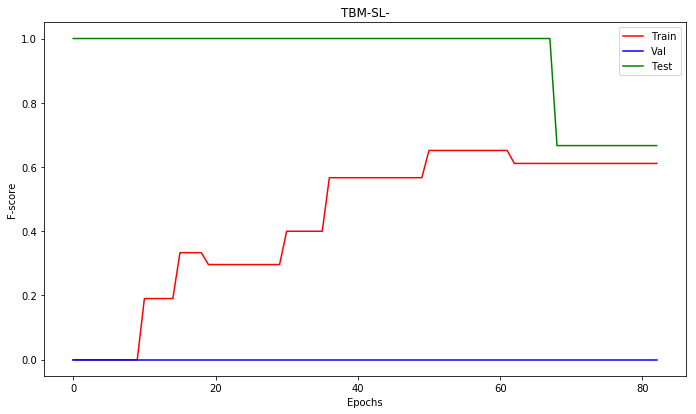

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=83=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.12it/s]


==========Epoch No:83==========
Training Loss: 25.078897953033447
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




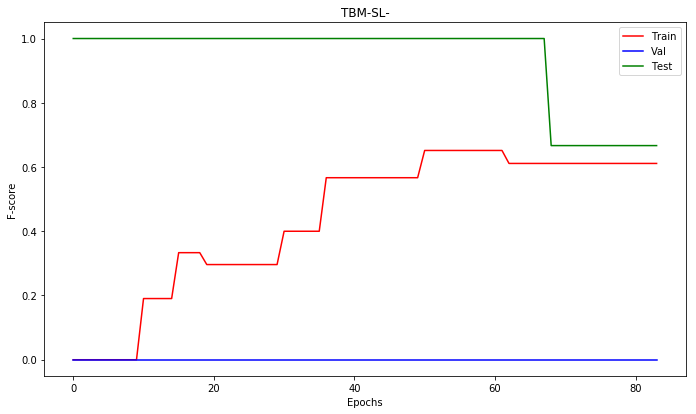

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=84=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.05it/s]


==========Epoch No:84==========
Training Loss: 25.051813006401062
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




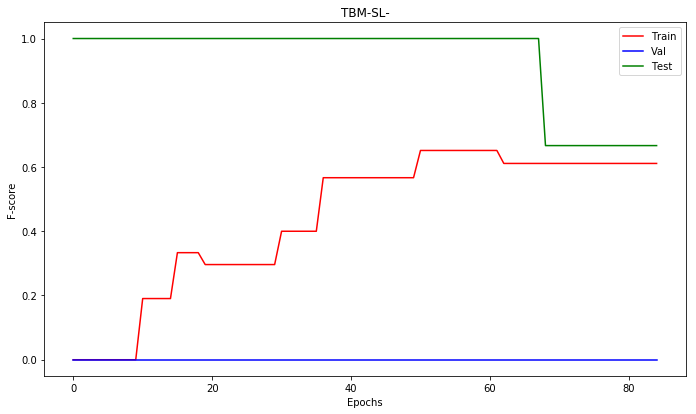

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=85=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.05it/s]


==========Epoch No:85==========
Training Loss: 25.02544355392456
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




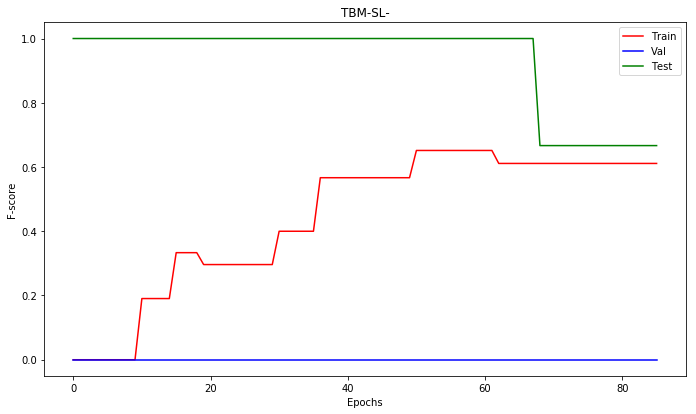

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=86=#==#==#==#==#=


100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


==========Epoch No:86==========
Training Loss: 24.999645352363586
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




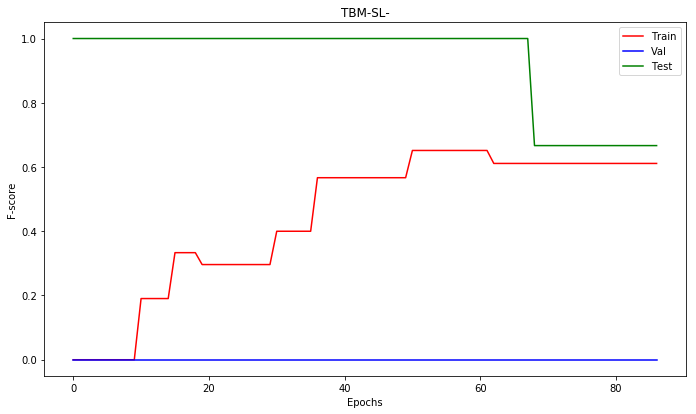

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=87=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


==========Epoch No:87==========
Training Loss: 24.97426688671112
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




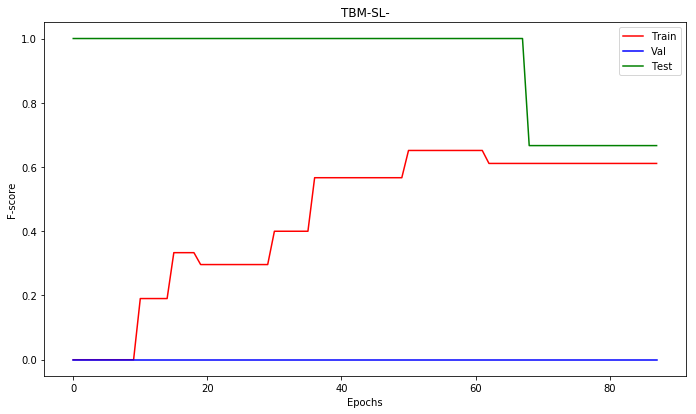

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=88=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


==========Epoch No:88==========
Training Loss: 24.949206590652466
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




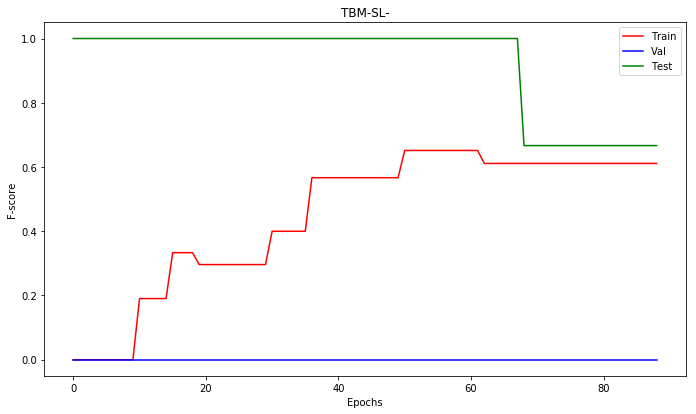

  0%|          | 0/17 [00:00<?, ?it/s]

=#==#==#==#==#=89=#==#==#==#==#=


100%|██████████| 17/17 [00:15<00:00,  1.16it/s]


==========Epoch No:89==========
Training Loss: 24.924370884895325
Train: (0.8235294117647058, 0.35294117647058826, 0.4264705882352941, None)
                  0         1
Precision  1.000000  0.666667
Recall     0.333333  0.666667
F-score    0.500000  0.666667
Count      3.000000  6.000000
--------
Val: (0.0, 0.0, 0.0, None)
             0    1
Precision  0.0  0.0
Recall     0.0  0.0
F-score    0.0  0.0
Count      0.0  1.0
--------
Test: (0.7857142857142857, 0.2857142857142857, 0.33333333333333337, None)
                  0    1
Precision  0.500000  0.0
Recall     1.000000  0.0
F-score    0.666667  0.0
Count      1.000000  0.0




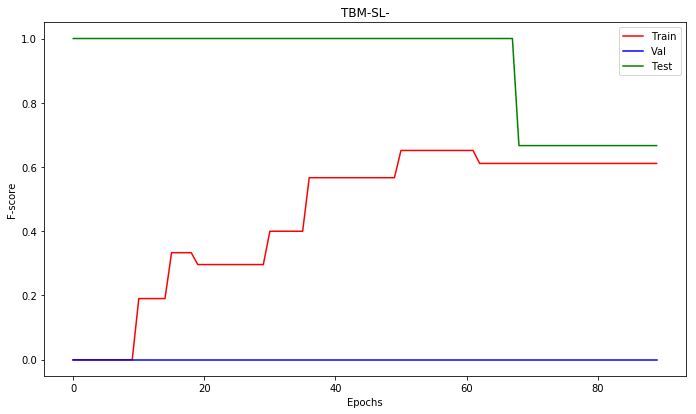

In [9]:
start_epoch = 0
end_epoch = 90
model_name = params['model_name']
for iter_ in range(start_epoch, end_epoch):
    print ("=#="*5+str(iter_)+"=#="*5)
    total_loss = 0
    preds_train = []
    actual_train = []
    for each_ID in tqdm(data['train_ids']):
#         print each_ID
        model_RNN.zero_grad()
        tag_scores = model_RNN(data['data'], each_ID)
        
        _, ind_ = torch.max(tag_scores, dim=1)
        preds_train+=ind_.tolist()
        
        curr_labels = [data['data'][each_ID][-1]]
        print(curr_labels)
        sys.exit()
#         curr_labels = [batchify.label_mapping[x] for x in curr_labels]
        actual_train+=curr_labels
#         curr_labels = torch.cuda.LongTensor(curr_labels)
        curr_labels = torch.LongTensor(curr_labels)
        curr_labels = autograd.Variable(curr_labels)
        
        loss = loss_function(tag_scores, curr_labels.reshape(tag_scores.shape[0]))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
    df_tr = pd.DataFrame(list(precision_recall_fscore_support(actual_train, preds_train, labels = [0,1])),
                       columns = [0,1])
    df_tr.index = ['Precision','Recall','F-score','Count']
    prf_tr = precision_recall_fscore_support(actual_train, preds_train, average='weighted')
#     prf_tr, df_tr = evaluate_(model_RNN, data, 'train_ids')
    prf_test, df_test = eval_plot.evaluate_dbm(model_RNN, data, 'test_ids')
    prf_val, df_val = eval_plot.evaluate_dbm(model_RNN, data, 'val_ids')
    
    df_all = pd.concat([df_tr, df_val, df_test],axis=1)
    dict_df_prf_mod['Epoch'+str(iter_)] = df_all
    
    print('=='*5 + "Epoch No:"+str(iter_) +"=="*5)
    print("Training Loss: "+str(total_loss))
    print("=="*4)
    print("Train: " + str(prf_tr))
    print(df_tr)
    print("--"*4)
    print("Val: " + str(prf_val))
    print(df_val)
    print("--"*4)
    print("Test: " + str(prf_test))
    print(df_test)
    print('=='*40)
    print('\n')

    eval_plot.plot_graphs(dict_df_prf_mod, 'F-score', 
                  model_path + "/" +model_name+str(iter_)+'.png',
                  0, iter_+1, 
                  model_name)
#     if(save_flag):
#         torch.save(model_RNN, '../../Models/'+model_name+str(iter_)+'.pt')
#         pickle.dump(dict_df_prf_mod, open('../../Results/dict_prf_'+model_name+str(iter_)+'.pkl','wb'))
#         eval_plot.plot_graphs(dict_df_prf_mod, 'F-score', 
#                               '../../Plots/'+model_name+str(iter_)+'.png',
#                               0, iter_+1, 
#                               model_name)